In [247]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import torch
from sklearn.model_selection import train_test_split
%matplotlib inline

In [229]:
np.random.seed(123)

In [328]:
target_names = ['Iris-setosa', 'Iris-virginica', 'Iris-versicolor']
feature_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

In [263]:
PARAMETERS = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
    'num_epochs': [100, 500, 1000, 5000, 10000, 30000, 50000, 100000, 200000, 300000],
    'split_rate': [0.1, 0.2, 0.3, 0.4, 0.5 ,0.6, 0.7]
}

#### Iris classification with 2 layered NN

In [360]:
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

def prepare_iris_xy(filename="Iris.csv", encode=True):
    ### Шаг 2. Подготовка тренировочных данных
    # получения данных из csv файла. укажите здесь путь к файлу Iris.csv
    iris_data = pd.read_csv(filename)
    # print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

    # репрезентация данных в виде графиков
    # g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
    # plt.show() # расскоментируйте, чтобы посмотреть

    # замена текстовых значений на цифровые
    iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

    # формирование входных данных
    columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
    x = pd.DataFrame(iris_data, columns=columns)
    x = normalize(x.values)

    # формирование выходных данных(результатов)
    columns = ['Species']
    y = pd.DataFrame(iris_data, columns=columns)
    y = y.values
    y = y.flatten()
    if encode:
        y = to_one_hot(y)
    return x, y


def iris_net(x,y, learning_rate=0.1, num_epochs=15000, split_rate=0.3, plot_iter_dependance=False):

    # Разделение данных на тренировочные и тестовые
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=split_rate)
    
    # Обученние нейронной сети
    # присваевание случайных весов
    w0 = 2*np.random.random((4, 5)) - 1 # для входного слоя   - 4 входа, 3 выхода
    w1 = 2*np.random.random((5, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода

    # массив для ошибок, чтобы потом построить график
    errors = []

    # процесс обучения
    for i in range(num_epochs):

        # прямое распространение(feed forward)
        layer0 = X_train
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2
        layer2_delta = layer2_error * sigmoid_deriv(layer2)

        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)

        w1 += layer1.T.dot(layer2_delta) * learning_rate
        w0 += layer0.T.dot(layer1_delta) * learning_rate

        error = np.mean(np.abs(layer2_error))
        errors.append(error)
        accuracy = (1 - error)
    if plot_iter_dependance:
        show_results(errors, accuracy)
    return accuracy
        
    
def show_results(errors, accuracy):
    
    # График зависимости точности модели от длительности обучения
    
    plt.plot(errors)
    plt.xlabel('Обучение')
    plt.ylabel('Ошибка')
    plt.show() 
    print("Точность нейронной сети " + str(round(accuracy,2)))


In [278]:
# Подготовка данных к обучению
x, y = prepare_iris_xy()

## Оценка влияния скорости обучения и количества итераций на точность модели

В текущей модели настраиваются 2 основных параметра: количество эпох и скорость обучения. При высокой скорости обучения сеть быстрее достигает высокой точности, что важно при небольшом количестве эпох. На большом числе итераций высокйи lr приводит к скачкообразным изменениям точности на градиентном шаге. Низкая скорость обучения требует большее кол-во итераций, точность растет более плавно, но может застрять в локальном минимуме.

Значительную роль может сыграть выбор фукнции активации и метода оптимизации сети.

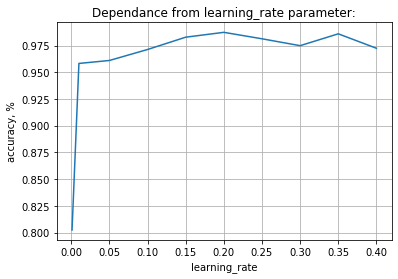

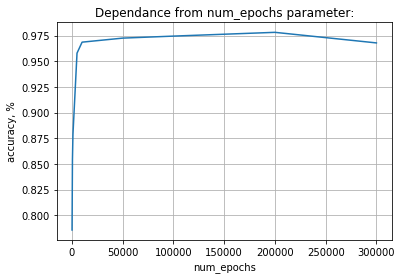

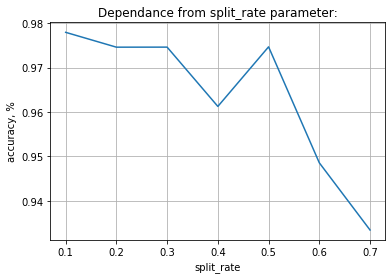

In [280]:
# Оценка влияния параметров нейросети на точность


for key in PARAMETERS:
    par = PARAMETERS.get(key)
    acc = []
    for v in par:
        kwargs = {key:v}
        tmp_res = iris_net(x,y, **kwargs)
        acc.append(tmp_res)
    plt.plot(par, acc)
    plt.xlabel(f"{key}")
    plt.ylabel(f"accuracy, %")
    plt.grid()
    plt.title(f"Dependance from {key} parameter:")
    plt.show()


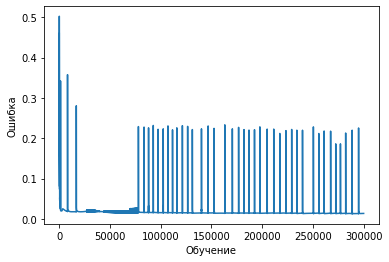

Точность нейронной сети 0.99


0.9862859348922761

In [243]:
iris_net(x, y, learning_rate=0.4, num_epochs=300000, plot_iter_dependance=True) # acc: 0.99

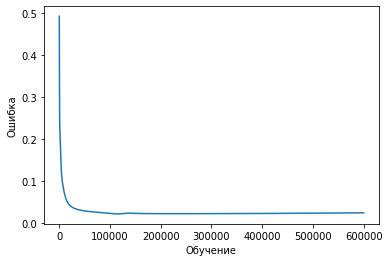

Точность нейронной сети 0.98


0.9754600697988605

In [245]:
iris_net(x, y, learning_rate=0.01, num_epochs=600000, plot_iter_dependance=True)

### Вариант реализации с помощью torch

In [427]:
x, y = prepare_iris_xy(encode=False)
X_train, X_test, y_train, y_test = train_test_split(x[:, :2], y, test_size=0.3, shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

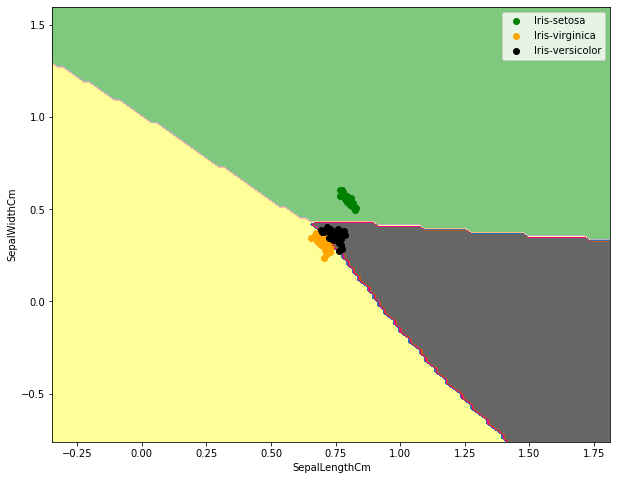

In [428]:
batch_size = 10
n_hidden = 40 # кол-во скрытых нейронов


class IrisNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(IrisNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons) # Входные нейроны по кол-ву признаков
        self.activ1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3) # 3 выходных нейрона
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
_iris_net = IrisNet(n_hidden)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(_iris_net.parameters(), 
                             lr=1.0e-3)

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = _iris_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = _iris_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        # print((test_preds == y_test).float().mean())

        
# Вывод графика зависимости 

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = _iris_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=target_names[i],
                cmap='Accent')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend()